## Importación de librerías y carga de archivos

In [1]:
import pandas as pd
import numpy as np
import unicodedata
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

## FUNCIONES AUXILIARES

In [ ]:
def analisis_completo_dataset(df):
    print(f"Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
    print(f"\nTipos de datos:")
    print(df.dtypes.value_counts())
    
    print(f"\nValores nulos por columna:")
    nulos = df.isnull().sum()
    nulos_pct = (nulos / len(df)) * 100
    for col in df.columns:
        if nulos[col] > 0:
            print(f"  {col}: {nulos[col]} ({nulos_pct[col]:.1f}%)")
        
    return nulos_pct
def normalizar_columnas(df):
    def clean_column_name(col_name):
        normalized = unicodedata.normalize('NFD', str(col_name))
        ascii_str = normalized.encode('ascii', 'ignore').decode('ascii')
        cleaned = ascii_str.lower().replace(' ', '_')
        cleaned = re.sub(r'[^a-z0-9_]', '', cleaned)
        return cleaned
    df = df.copy()
    df.columns = [clean_column_name(col) for col in df.columns]
    return df
def preparar_ids(df, columnas_id):
    df = df.copy()
    for col in columnas_id:
        if col in df.columns:
            df = df.dropna(subset=[col])
            df[col] = df[col].astype(str).str.replace('.0', '', regex=False)
    return df
def limpiar_nulos(df, dataset_name, umbral=0.5):
    df = df.copy()
    total_rows = len(df)
    nulos = df.isnull().sum() / total_rows
    cols_eliminar = nulos[nulos > umbral].index.tolist()
    if cols_eliminar:
        print(f"\n[{dataset_name}] Eliminando columnas con más del {umbral*100:.0f}% de nulos:")
        for col in cols_eliminar:
            print(f"   - {col} ({nulos[col]*100:.1f}% nulos)")
        df = df.drop(columns=cols_eliminar)
    print(f"[{dataset_name}] Columnas restantes: {len(df.columns)}")
    return df
def detectar_outliers(df, col, dataset_name):
    if col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        print(f"[{dataset_name}] {len(outliers)} posibles outliers detectados en '{col}'.")
    return df
def eliminar_columnas(df, columnas_a_eliminar, dataset_name):
    df = df.copy()
    existentes = [col for col in columnas_a_eliminar if col in df.columns]
    if existentes:
        print(f"[{dataset_name}] Eliminando columnas: {existentes}")
        df = df.drop(columns=existentes)
    else:
        print(f"[{dataset_name}] Ninguna de las columnas a eliminar fue encontrada.")
    return df
def verificar_nulos(df, nombre_merge):
    print(f"\n[{nombre_merge}] - Valores nulos en las columnas clave:")
    print(df.isnull().sum())
def heatmap_nulos(df, title="Mapa de calor de nulos"):
    plt.figure(figsize=(12,6))
    sns.heatmap(df.isnull(), cbar=False, cmap="Blues", yticklabels=False)
    plt.title(title)
    plt.xlabel("Columnas")
    plt.ylabel("Filas")
    plt.show()



## CARGAR ARCHIVOS

In [3]:
print("Cargando archivos...")
medicamentos = pd.read_excel("../data/Medicamento.xlsx")
compra = pd.read_excel("../data/Compra2.xlsx")
detalle_venta = pd.read_excel("../data/Venta2.xlsx")
venta = pd.read_excel("../data/Venta.xlsx")

Cargando archivos...


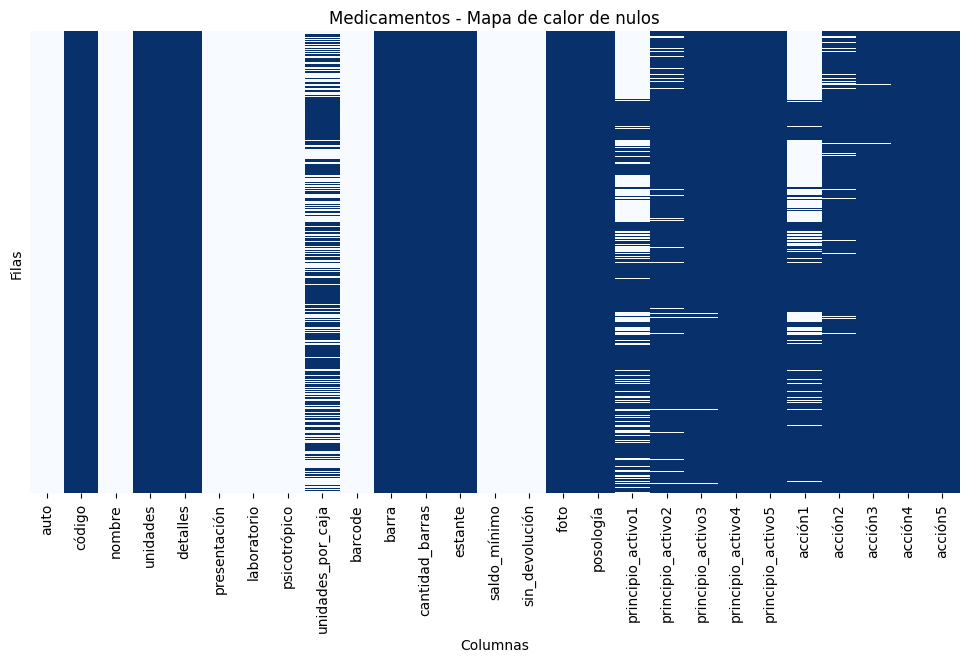

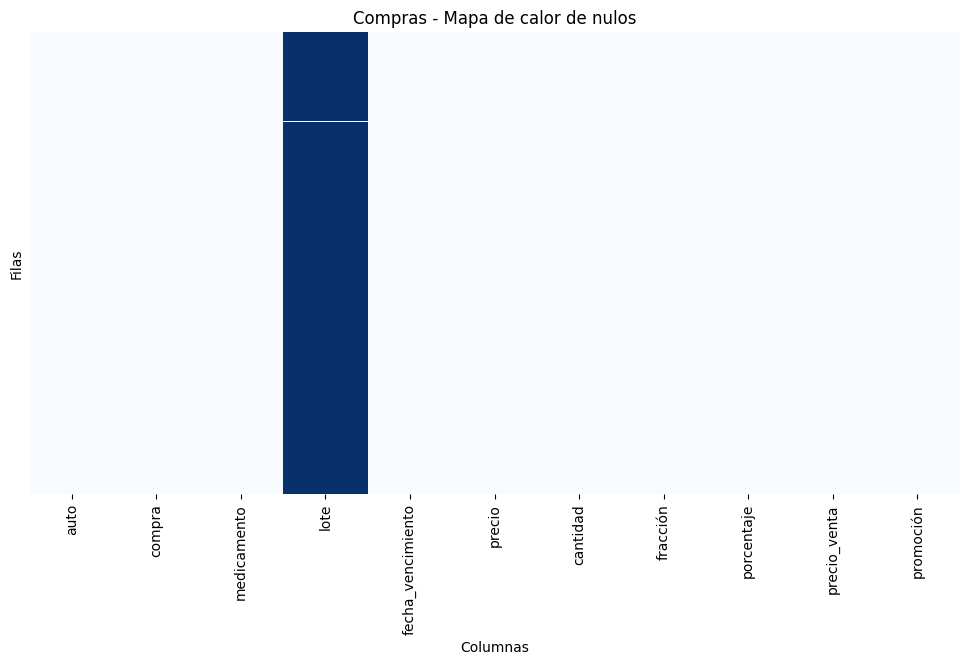

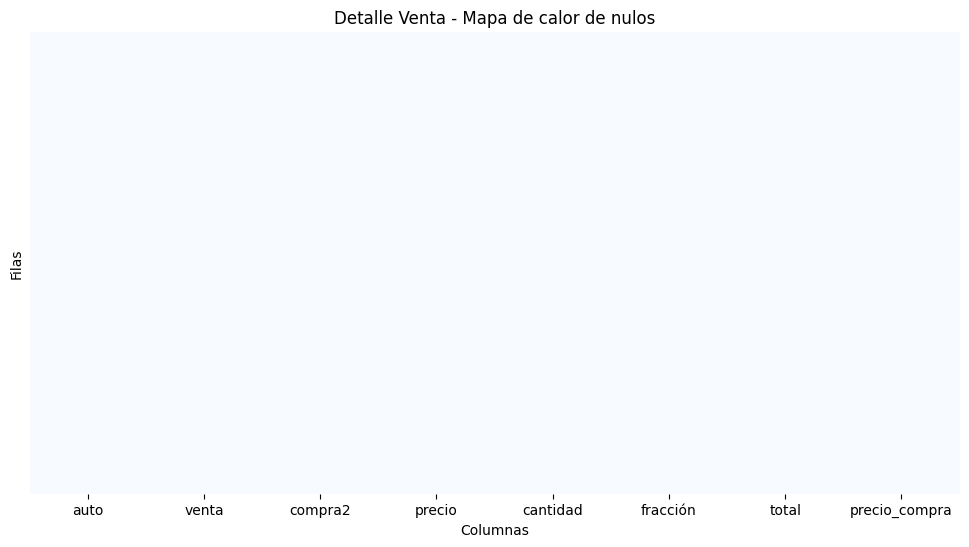

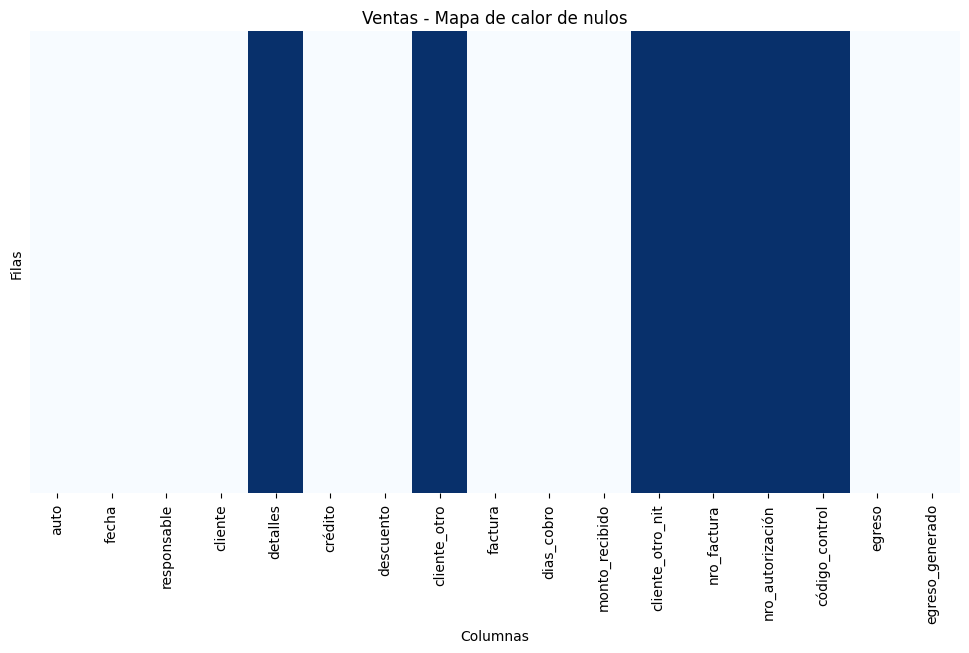

In [4]:
# Vista de mapa de calor de nulos
heatmap_nulos(medicamentos, title="Medicamentos - Mapa de calor de nulos")
heatmap_nulos(compra, title="Compras - Mapa de calor de nulos")
heatmap_nulos(detalle_venta, title="Detalle Venta - Mapa de calor de nulos")
heatmap_nulos(venta, title="Ventas - Mapa de calor de nulos")

In [ ]:
# Visualización de la distribución de las ventas
plt.figure(figsize=(10, 6))
sns.boxplot(data=venta['monto_recibido'])
plt.title('Distribución de Ventas - Monto Recibido')
plt.ylabel('Monto')
plt.show()

# Histograma
plt.figure(figsize=(10, 6))
plt.hist(venta['monto_recibido'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma de Ventas - Monto Recibido')
plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.show()


## LIMPIEZA POR DATASET

### Medicamentos

In [5]:
print("\nLimpieza: Medicamentos")
medicamentos = normalizar_columnas(medicamentos)
medicamentos = preparar_ids(medicamentos, ['auto'])
# Convertir numéricos
for col in ['unidades_por_caja', 'cantidad_barras', 'saldo_minimo']:
    if col in medicamentos.columns:
        medicamentos[col] = pd.to_numeric(medicamentos[col], errors='coerce')
# Booleanos
for col in ['psicotropico', 'sin_devolucion', 'barcode']:
    if col in medicamentos.columns:
        medicamentos[col] = medicamentos[col].astype(bool)
# Duplicados
medicamentos = medicamentos.drop_duplicates(subset=['auto'], keep='first')
# Nulos
medicamentos = limpiar_nulos(medicamentos, "Medicamentos")
# Eliminar columnas innecesarias
medicamentos = eliminar_columnas(medicamentos, ["presentacion", "laboratorio", "psicotropico", "barcode", "saldo_minimo", "sin_devolucion"], "Medicamentos")
# Columnas finales 
print(medicamentos.columns.tolist())


Limpieza: Medicamentos

[Medicamentos] Eliminando columnas con más del 50% de nulos:
   - codigo (100.0% nulos)
   - unidades (100.0% nulos)
   - detalles (100.0% nulos)
   - unidades_por_caja (61.6% nulos)
   - barra (100.0% nulos)
   - cantidad_barras (100.0% nulos)
   - estante (100.0% nulos)
   - foto (100.0% nulos)
   - posologia (100.0% nulos)
   - principio_activo1 (56.7% nulos)
   - principio_activo2 (93.2% nulos)
   - principio_activo3 (98.7% nulos)
   - principio_activo4 (100.0% nulos)
   - principio_activo5 (100.0% nulos)
   - accion1 (60.1% nulos)
   - accion2 (94.9% nulos)
   - accion3 (99.3% nulos)
   - accion4 (100.0% nulos)
   - accion5 (100.0% nulos)
[Medicamentos] Columnas restantes: 8
[Medicamentos] Eliminando columnas: ['presentacion', 'laboratorio', 'psicotropico', 'barcode', 'saldo_minimo', 'sin_devolucion']
['auto', 'nombre']


### Compras

In [6]:
print("\nLimpieza: Compras")
compra = normalizar_columnas(compra)
compra = preparar_ids(compra, ['auto', 'medicamento'])
# Fechas
if 'fecha_vencimiento' in compra.columns:
    compra['fecha_vencimiento'] = pd.to_datetime(compra['fecha_vencimiento'], errors='coerce')
# Numéricos
for col in ['precio', 'cantidad', 'fraccion', 'porcentaje', 'precio_venta']:
    if col in compra.columns:
        compra[col] = pd.to_numeric(compra[col], errors='coerce')
# Booleanos
if 'promocion' in compra.columns:
    compra['promocion'] = compra['promocion'].astype(bool)
# Duplicados
compra = compra.drop_duplicates(subset=['auto'], keep='first')
# Nulos
compra = limpiar_nulos(compra, "Compras")
# Eliminar columnas innecesarias
compra = eliminar_columnas(compra, ["porcentaje", "promocion", "precio", "cantidad", "fraccion", "precio_venta", "fecha_vencimiento"], "Compras")
# Columnas finales
print(compra.columns.tolist())


Limpieza: Compras

[Compras] Eliminando columnas con más del 50% de nulos:
   - lote (99.9% nulos)
[Compras] Columnas restantes: 10
[Compras] Eliminando columnas: ['porcentaje', 'promocion', 'precio', 'cantidad', 'fraccion', 'precio_venta', 'fecha_vencimiento']
['auto', 'compra', 'medicamento']


### Detalle de venta

In [7]:
print("\nLimpieza: Detalle de venta")
detalle_venta = normalizar_columnas(detalle_venta)
detalle_venta = preparar_ids(detalle_venta, ['auto', 'venta', 'compra2'])
# Numéricos
for col in ['precio', 'cantidad', 'fraccion', 'total', 'precio_compra']:
    if col in detalle_venta.columns:
        detalle_venta[col] = pd.to_numeric(detalle_venta[col], errors='coerce')
# Validación consistencia total
if set(['precio', 'cantidad', 'fraccion', 'total']).issubset(detalle_venta.columns):
    detalle_venta['total_calc'] = detalle_venta['precio'] * (detalle_venta['cantidad'] + detalle_venta['fraccion'])
    inconsistentes = detalle_venta[np.abs(detalle_venta['total'] - detalle_venta['total_calc']) > 0.01]
    print(f"[Venta Detalle] {len(inconsistentes)} registros inconsistentes en cálculo de total.")
    detalle_venta = detalle_venta.drop(columns=['total_calc'])
# Duplicados
detalle_venta = detalle_venta.drop_duplicates(subset=['auto'], keep='first')
# Nulos
detalle_venta = limpiar_nulos(detalle_venta, "Venta Detalles")
# Columnas finales
print(detalle_venta.columns.tolist())


Limpieza: Detalle de venta
[Venta Detalle] 456 registros inconsistentes en cálculo de total.
[Venta Detalles] Columnas restantes: 8
['auto', 'venta', 'compra2', 'precio', 'cantidad', 'fraccion', 'total', 'precio_compra']


### Venta

In [8]:
print("\nLimpieza: Venta Encabezados")
venta = normalizar_columnas(venta)
venta = preparar_ids(venta, ['auto', 'cliente'])
# Fechas
if 'fecha' in venta.columns:
    venta['fecha'] = pd.to_datetime(venta['fecha'], errors='coerce')
# Numéricos
for col in ['monto_recibido', 'descuento', 'dias_cobro']:
    if col in venta.columns:
        venta[col] = pd.to_numeric(venta[col], errors='coerce')
# Booleanos
for col in ['credito', 'factura', 'egreso', 'egreso_generado']:
    if col in venta.columns:
        venta[col] = venta[col].astype(bool)
# Filtrar registros inválidos
if 'monto_recibido' in venta.columns:
    venta = venta[venta['monto_recibido'] > 0]
# Duplicados
venta = venta.drop_duplicates(subset=['auto'], keep='first')
# Nulos
venta = limpiar_nulos(venta, "Venta Encabezados")
# Outliers
venta = detectar_outliers(venta, 'monto_recibido', "Venta Encabezados")
# Eliminar columnas innecesarias
venta = eliminar_columnas(venta, ["responsable", "cliente", "credito", "descuento", "factura", "dias_cobro", "egreso", "egreso_generado"], "Venta Encabezados")
# Columnas finales
print(venta.columns.tolist())


Limpieza: Venta Encabezados

[Venta Encabezados] Eliminando columnas con más del 50% de nulos:
   - detalles (100.0% nulos)
   - cliente_otro (100.0% nulos)
   - cliente_otro_nit (100.0% nulos)
   - nro_factura (100.0% nulos)
   - nro_autorizacion (100.0% nulos)
   - codigo_control (100.0% nulos)
[Venta Encabezados] Columnas restantes: 11
[Venta Encabezados] 897 posibles outliers detectados en 'monto_recibido'.
[Venta Encabezados] Eliminando columnas: ['responsable', 'cliente', 'credito', 'descuento', 'factura', 'dias_cobro', 'egreso', 'egreso_generado']
['auto', 'fecha', 'monto_recibido']


## Unificación final

In [9]:
print("medicamentos:", medicamentos.columns.tolist())
print("venta:", venta.columns.tolist())
print("detalle_venta:", detalle_venta.columns.tolist())
print("compra:", compra.columns.tolist())

medicamentos: ['auto', 'nombre']
venta: ['auto', 'fecha', 'monto_recibido']
detalle_venta: ['auto', 'venta', 'compra2', 'precio', 'cantidad', 'fraccion', 'total', 'precio_compra']
compra: ['auto', 'compra', 'medicamento']


In [10]:
# Merge 1: venta + detalle_venta
resultado = venta.merge(detalle_venta, left_on='auto', right_on='venta', how='left', suffixes=('_venta', '_detalle'))
verificar_nulos(resultado, "venta + detalle_venta")

# Merge 2: + compra
resultado = resultado.merge(compra, left_on='compra2', right_on='auto', how='left', suffixes=('', '_compra'))
verificar_nulos(resultado, "venta + detalle_venta + compra")

# Merge 3: + medicamentos
dataset_final = resultado.merge(medicamentos, left_on='medicamento', right_on='auto', how='left', suffixes=('', '_med'))
verificar_nulos(dataset_final, "venta + detalle_venta + compra + medicamentos")



[venta + detalle_venta] - Valores nulos en las columnas clave:
auto_venta        0
fecha             0
monto_recibido    0
auto_detalle      0
venta             0
compra2           0
precio            0
cantidad          0
fraccion          0
total             0
precio_compra     0
dtype: int64

[venta + detalle_venta + compra] - Valores nulos en las columnas clave:
auto_venta        0
fecha             0
monto_recibido    0
auto_detalle      0
venta             0
compra2           0
precio            0
cantidad          0
fraccion          0
total             0
precio_compra     0
auto              0
compra            0
medicamento       0
dtype: int64

[venta + detalle_venta + compra + medicamentos] - Valores nulos en las columnas clave:
auto_venta        0
fecha             0
monto_recibido    0
auto_detalle      0
venta             0
compra2           0
precio            0
cantidad          0
fraccion          0
total             0
precio_compra     0
auto              0
compra   

In [11]:
dataset_final.columns.tolist()

['auto_venta',
 'fecha',
 'monto_recibido',
 'auto_detalle',
 'venta',
 'compra2',
 'precio',
 'cantidad',
 'fraccion',
 'total',
 'precio_compra',
 'auto',
 'compra',
 'medicamento',
 'auto_med',
 'nombre']

## Exportar resultado

In [12]:
dataset_final.to_csv('../output/dataset_farmacia_unificado.csv', index=False, encoding='utf-8')
print("Dataset exportado: dataset_farmacia_unificado.csv")
print("Forma final: ", dataset_final.shape)
print("Listado de columnas:")
print(dataset_final.columns.tolist())

Dataset exportado: dataset_farmacia_unificado.csv
Forma final:  (171867, 16)
Listado de columnas:
['auto_venta', 'fecha', 'monto_recibido', 'auto_detalle', 'venta', 'compra2', 'precio', 'cantidad', 'fraccion', 'total', 'precio_compra', 'auto', 'compra', 'medicamento', 'auto_med', 'nombre']


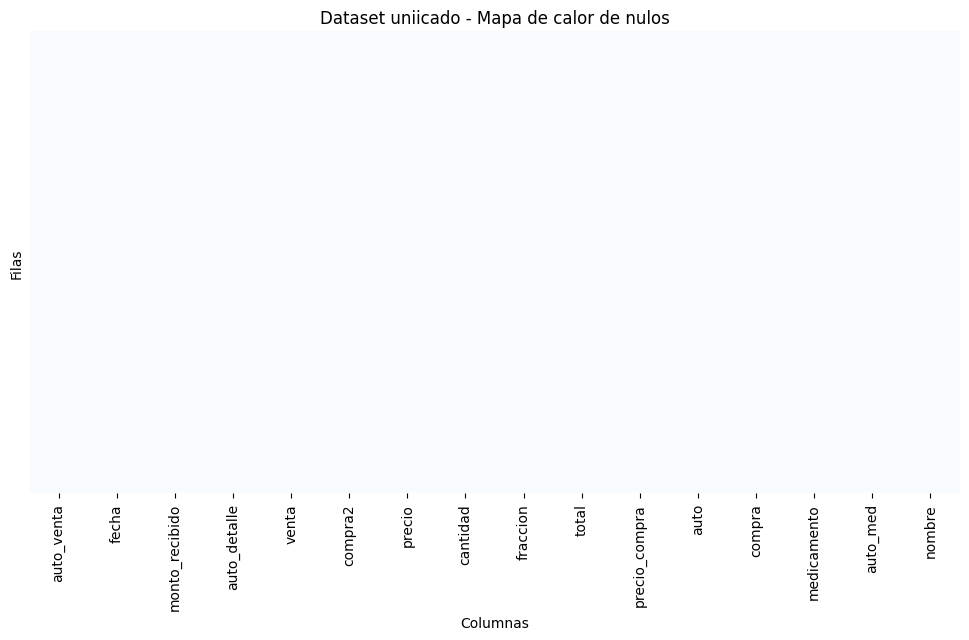

In [14]:
heatmap_nulos(dataset_final, title="Dataset uniicado - Mapa de calor de nulos")